<a href="https://colab.research.google.com/github/mansibora20/PySpark/blob/main/05_DataFrames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import random
from datetime import datetime, timedelta
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DateType

Initialize Spark Session

In [2]:
spark = SparkSession.builder.appName("SparkDataFrames").getOrCreate()

Define schema

In [3]:
schema = StructType([
    StructField("flight_id", IntegerType(), False),
    StructField("airline", StringType(), False),
    StructField("departure_airport", StringType(), False),
    StructField("arrival_airport", StringType(), False),
    StructField("departure_time", DateType(), False),
    StructField("arrival_time", DateType(), False),
    StructField("passenger_id", IntegerType(), False),
    StructField("ticket_price", FloatType(), False),
    StructField("seat_class", StringType(), False),
    StructField("delay_minutes", IntegerType(), True),
    StructField("loyalty_member", StringType(), False)
])

Generate data

In [4]:
airlines = ["Del", "Uni", "Ami", "Southern", "Jet"]
airports = ["JFK", "LAX", "ORD", "ATL", "DFW", "DEN", "SFO", "MIA"]
seat_classes = ["Economy", "Business", "First Class"]
loyalty_status = ["Yes", "No"]

data = []
start_date = datetime(2023, 1, 1)

for i in range(10000):  # 10,000 flight records
    flight_id = random.randint(1000, 9999)
    airline = random.choice(airlines)
    dep_airport, arr_airport = random.sample(airports, 2)
    departure_time = start_date + timedelta(days=random.randint(0, 365))
    arrival_time = departure_time + timedelta(hours=random.randint(2, 10))
    passenger_id = random.randint(5000, 15000)
    ticket_price = round(random.uniform(100, 2000), 2)
    seat_class = random.choice(seat_classes)
    delay_minutes = random.choice([0, 15, 30, 45, 60, 90, 120]) if random.random() < 0.3 else 0
    loyalty_member = random.choice(loyalty_status)

    data.append((flight_id, airline, dep_airport, arr_airport, departure_time, arrival_time,
                 passenger_id, ticket_price, seat_class, delay_minutes, loyalty_member))


Create DataFrame

In [5]:
df = spark.createDataFrame(data, schema)

Show sample data

In [6]:
df.show(10, truncate=False)

+---------+--------+-----------------+---------------+--------------+------------+------------+------------+-----------+-------------+--------------+
|flight_id|airline |departure_airport|arrival_airport|departure_time|arrival_time|passenger_id|ticket_price|seat_class |delay_minutes|loyalty_member|
+---------+--------+-----------------+---------------+--------------+------------+------------+------------+-----------+-------------+--------------+
|6145     |Uni     |ORD              |DFW            |2023-06-27    |2023-06-27  |6725        |1872.29     |Business   |0            |Yes           |
|5311     |Southern|MIA              |DFW            |2023-04-26    |2023-04-26  |5610        |213.8       |Economy    |120          |No            |
|5774     |Uni     |MIA              |SFO            |2023-06-01    |2023-06-01  |12316       |547.67      |First Class|0            |Yes           |
|7071     |Uni     |DEN              |DFW            |2023-02-20    |2023-02-20  |12203       |1815.

 Top 5 Most Frequent Flight Routes

In [7]:
from pyspark.sql.functions import count

top_routes = df.groupBy("departure_airport", "arrival_airport").agg(count("*").alias("total_flights"))
top_routes.orderBy("total_flights", ascending=False).show(5)

+-----------------+---------------+-------------+
|departure_airport|arrival_airport|total_flights|
+-----------------+---------------+-------------+
|              LAX|            SFO|          216|
|              MIA|            LAX|          207|
|              DEN|            SFO|          203|
|              SFO|            JFK|          203|
|              JFK|            ORD|          199|
+-----------------+---------------+-------------+
only showing top 5 rows



Airline Revenue Analysis

In [8]:
from pyspark.sql.functions import sum

revenue_per_airline = df.groupBy("airline").agg(sum("ticket_price").alias("total_revenue"))
revenue_per_airline.orderBy("total_revenue", ascending=False).show()

+--------+------------------+
| airline|     total_revenue|
+--------+------------------+
|     Uni| 2160811.689453125|
|     Ami|  2124476.02973938|
|Southern|2084319.5697402954|
|     Jet|2075340.6700286865|
|     Del|2058192.9096984863|
+--------+------------------+



Impact of Flight Delays on Revenue


In [9]:
from pyspark.sql.functions import avg

delay_impact = df.groupBy("delay_minutes").agg(avg("ticket_price").alias("avg_ticket_price"))
delay_impact.orderBy("delay_minutes").show()

+-------------+------------------+
|delay_minutes|  avg_ticket_price|
+-------------+------------------+
|            0| 1048.206801568787|
|           15| 1072.215826222079|
|           30|  1067.45838695239|
|           45|1007.7427330840405|
|           60|1063.8229216260752|
|           90|1061.5144000236805|
|          120|1064.9684394836427|
+-------------+------------------+



Frequent vs. Occasional Travelers


In [10]:
from pyspark.sql.functions import countDistinct

customer_flight_counts = df.groupBy("passenger_id").agg(countDistinct("flight_id").alias("flight_count"))
frequent_travelers = customer_flight_counts.filter("flight_count > 5")
frequent_travelers.show(5)

+------------+------------+
|passenger_id|flight_count|
+------------+------------+
|        9207|           6|
|       14725|           6|
|       11307|           6|
|       14607|           6|
|       14581|           6|
+------------+------------+
only showing top 5 rows



Revenue Contribution by Seat Class

In [11]:
seat_class_revenue = df.groupBy("seat_class").agg(sum("ticket_price").alias("total_revenue"))
seat_class_revenue.orderBy("total_revenue", ascending=False).show()


+-----------+-----------------+
| seat_class|    total_revenue|
+-----------+-----------------+
|    Economy|3576908.360733032|
|First Class| 3468901.46018219|
|   Business|3457331.047744751|
+-----------+-----------------+



Flight Delay Analysis (Plotly)

In [12]:
import plotly.express as px

delay_pd = delay_impact.toPandas()
fig = px.line(delay_pd, x="delay_minutes", y="avg_ticket_price", markers=True,
              title="Impact of Delays on Ticket Prices",
              labels={"delay_minutes": "Delay (minutes)", "avg_ticket_price": "Avg Ticket Price ($)"})
fig.show()


In [13]:
import plotly.express as px

# Convert Spark DataFrame to Pandas
delay_pd = delay_impact.toPandas()

# Create the line plot
fig = px.line(delay_pd, x="delay_minutes", y="avg_ticket_price", markers=True,
              title="Impact of Delays on Ticket Prices",
              labels={"delay_minutes": "Delay (minutes)", "avg_ticket_price": "Avg Ticket Price ($)"})

# Add text labels showing both Delay (X) and Price (Y)
fig.update_traces(
    text=[f"Delay: {x} min\nPrice: ${y:.2f}" for x, y in zip(delay_pd["delay_minutes"], delay_pd["avg_ticket_price"])],
    textposition="top center",
    mode="markers+text"  # Show both markers and text labels
)

# Disable hover effects
fig.update_layout(hovermode=False)

# Show the updated plot
fig.show()


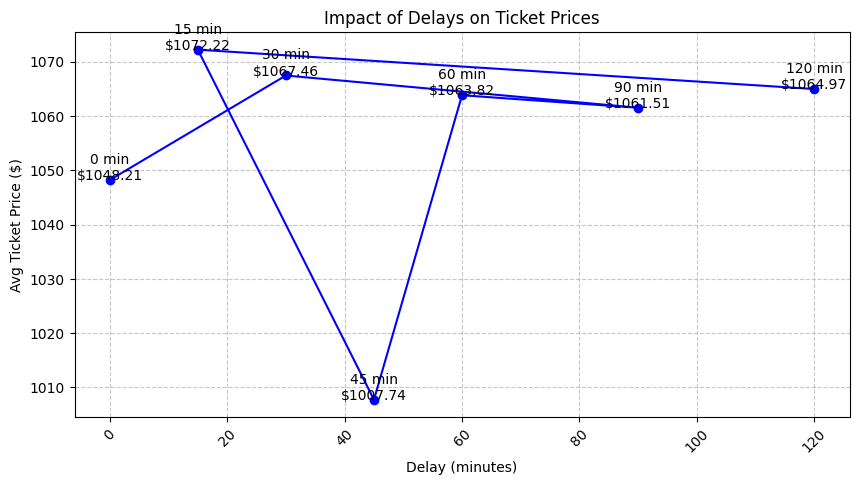

In [14]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
delay_pd = delay_impact.toPandas()

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(delay_pd["delay_minutes"], delay_pd["avg_ticket_price"], marker="o", linestyle="-", color="blue")

# Annotate points with values
for x, y in zip(delay_pd["delay_minutes"], delay_pd["avg_ticket_price"]):
    plt.text(x, y, f"{x} min\n${y:.2f}", ha="center", fontsize=10, color="black")

# Labels and title
plt.xlabel("Delay (minutes)")
plt.ylabel("Avg Ticket Price ($)")
plt.title("Impact of Delays on Ticket Prices")

# Grid and formatting
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)

# Save as an image for GitHub
plt.savefig("delay_vs_price.png", dpi=300, bbox_inches="tight")  # Saves as an image
plt.show()


Revenue by Airline (Matplotlib)

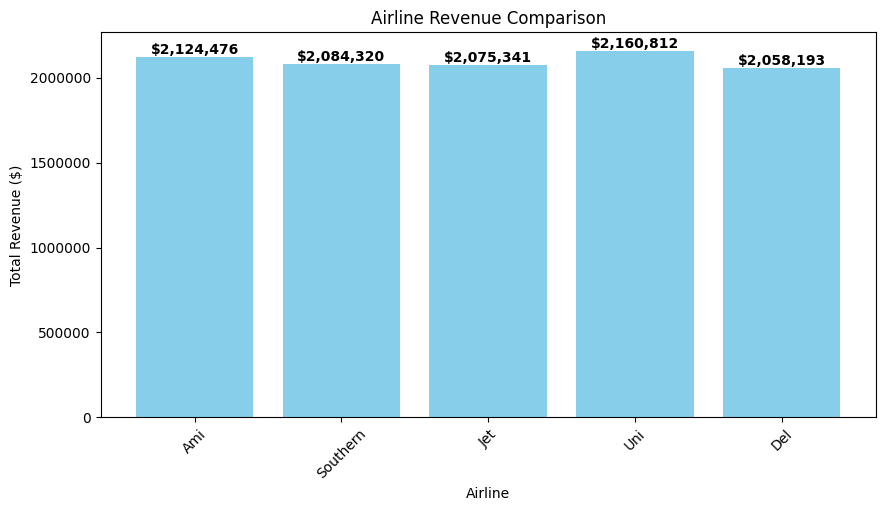

In [16]:
import matplotlib.pyplot as plt

# Ensure Spark DataFrame exists
if 'revenue_per_airline' in locals():
    # Convert Spark DataFrame to Pandas
    revenue_pd = revenue_per_airline.toPandas()
else:
    raise NameError("The Spark DataFrame 'revenue_per_airline' is not defined.")

# Convert revenue to normal float format
revenue_pd["total_revenue"] = revenue_pd["total_revenue"].astype(float)

plt.figure(figsize=(10, 5))
bars = plt.bar(revenue_pd["airline"], revenue_pd["total_revenue"], color="skyblue")

plt.xlabel("Airline")
plt.ylabel("Total Revenue ($)")
plt.title("Airline Revenue Comparison")
plt.xticks(rotation=45)

# Format Y-axis to avoid scientific notation
plt.ticklabel_format(style='plain', axis='y')

# Add text labels to bars (show revenue values on top of each bar)
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # X position (center of the bar)
        yval,  # Y position (height of the bar)
        f"${yval:,.0f}",  # Format with commas (e.g., $2,129,530)
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

plt.show()
